In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import json
from trackml.dataset import load_event, load_dataset
from trackml.randomize import shuffle_hits
from trackml.score import score_event
import timeit
from multiprocessing import Pool
import multiprocessing
import os
import random
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [ ]:
def load_data_single_event(event_number):
    file_name = 'event00000' + str(event_number)
    event_id = file_name
    hits, cells, particles, truth = load_event('data/train_sample/'+event_id)
    return hits, cells, particles, truth

In [ ]:
hits, cells, particles, truth = load_data_single_event(1000)

In [ ]:
ax = Axes3D( plt.figure(figsize=(20,20)))
sample = hits.sample(10000) ## pandas function, randomly samples given amount
layers = hits.layer_id.unique()
for layer in layers:
    l = sample[sample.layer_id == layer]
    ax.scatter(l.z, l.x, l.y, s=5, label='Layer '+str(layer), alpha=0.5)
ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.legend()
# These two added to widen the 3D space
ax.scatter(3000,3000,3000, s=0)
ax.scatter(-3000,-3000,-3000, s=0)
plt.show()

In [150]:
def cartesian_to_3d_polar(x, y, z):
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    #s  = np.sin(phi)
    #c  = np.cos(phi)
    return r, phi, z

No handles with labels found to put in legend.


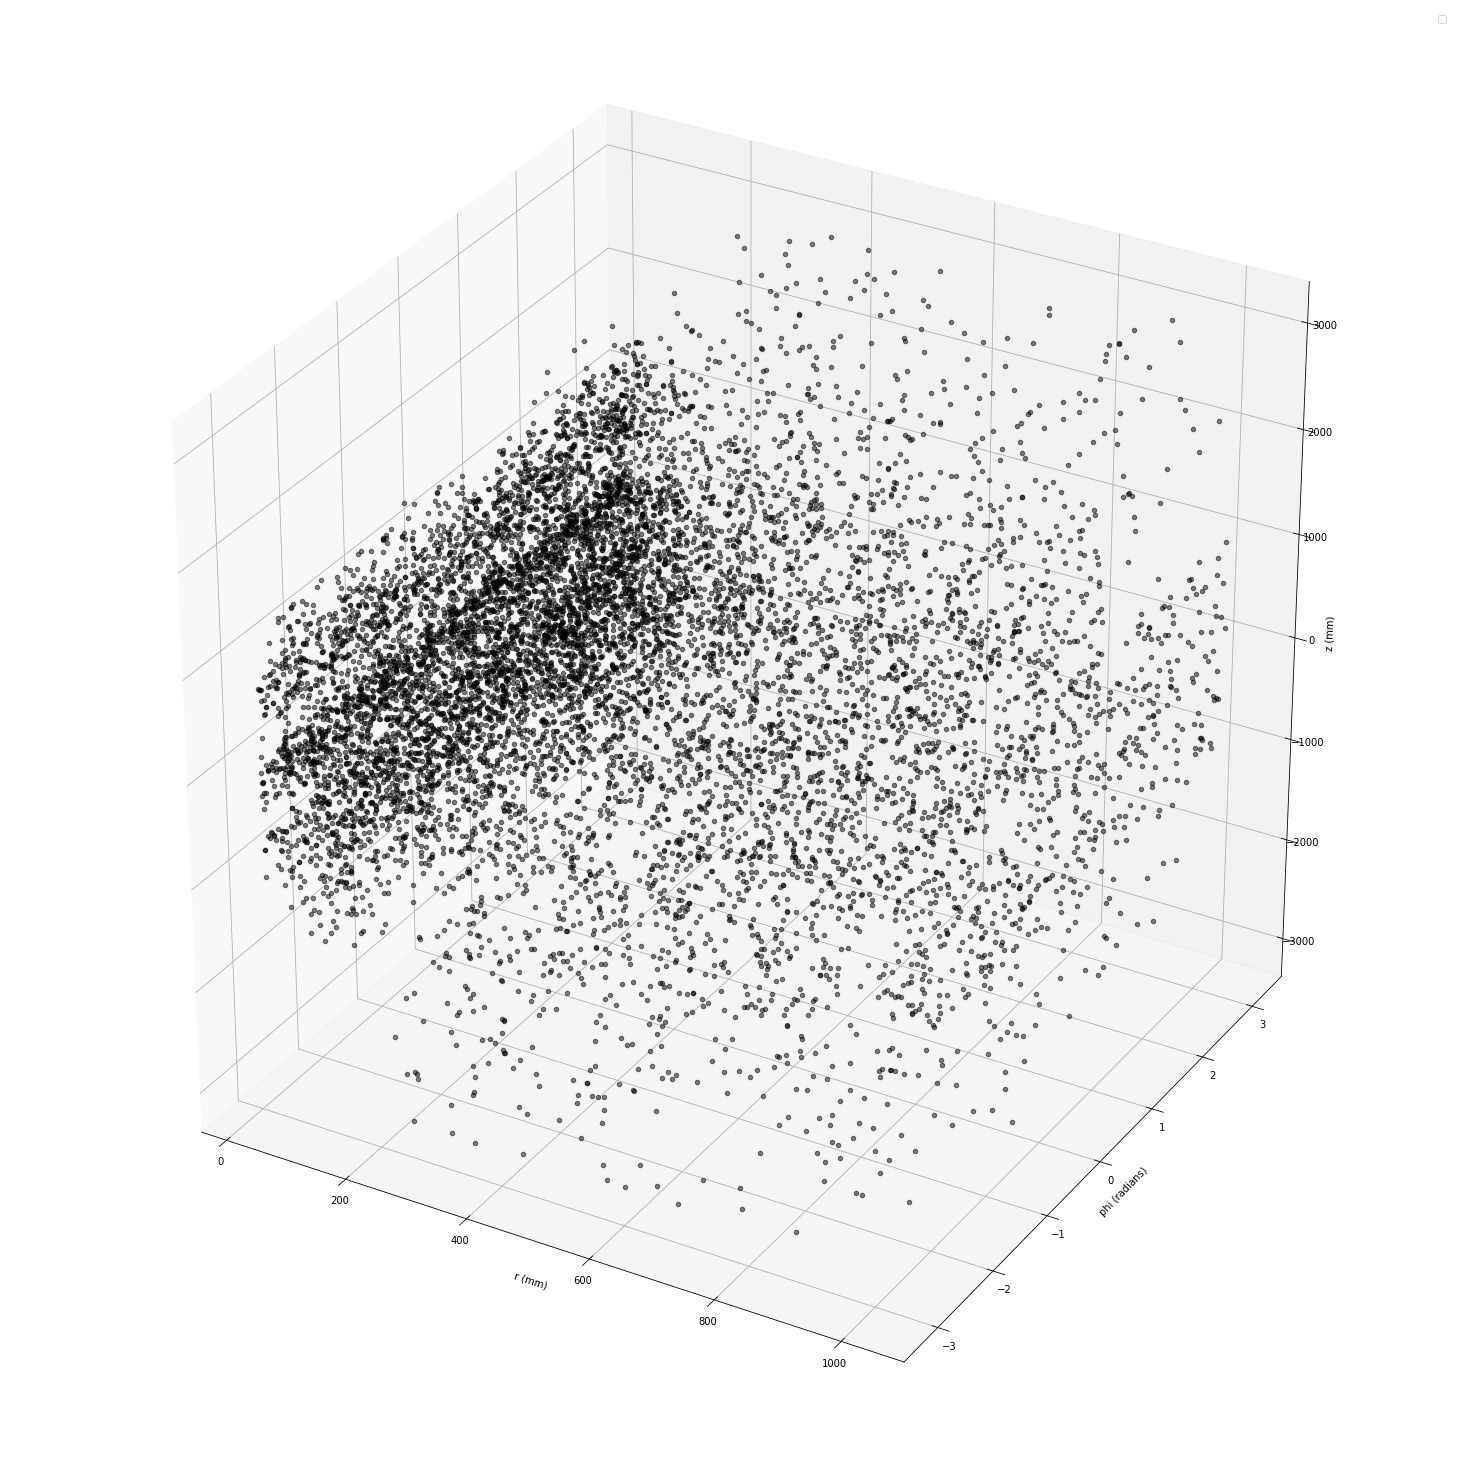

In [151]:
ax = Axes3D( plt.figure(figsize=(20,20)))
sample = hits.sample(10000) ## pandas function, randomly samples given amount
for row in sample.itertuples():
    ox = row.__getattribute__('x')
    oy = row.__getattribute__('y')
    oz = row.__getattribute__('z')
    r, phi, z,= cartesian_to_3d_polar(ox,oy,oz)
    ax.scatter(r, phi, z, alpha=0.5, c='0.0')
ax.set_xlabel('r (mm)')
ax.set_ylabel('phi (radians)')
ax.set_zlabel('z (mm)')
ax.legend()
# These two added to widen the 3D space
#ax.scatter(100,2*np.pi,100, s=0)
#ax.scatter(-100,-2*np.pi,-100, s=0)
plt.show()

In [184]:
grouped = test.groupby(['volume_id','layer_id'])['xyz'].apply(list).to_frame()

AttributeError: 'list' object has no attribute 'groupby'

In [ ]:
grouped2 = test.groupby(['volume_id','layer_id'])

In [ ]:
list(grouped2.groups.keys())

In [ ]:
axes = Axes3D(plt.figure(figsize=(20,20)))
unique
for (idx, row) in grouped.iterrows():
    #print(type(row))
    xyz = np.array(row['xyz'])
    x,y,z = xyz[:,0], xyz[:,1], xyz[:,2]
    axes.plot(x,y,z, linewidth=0.5)
    axes.scatter
#axes.text(x[0], y[0], z[0], str(idx), None)

plt.show() 

In [ ]:
unique_groups

In [ ]:
grouped_sample = sample.groupby(['volume_id','layer_id'])
unique_groups = list(grouped_sample.groups.keys())
sample['xyz'] = sample[['x','y','z']].values.tolist()
grouped = sample.groupby(['volume_id','layer_id'])['xyz'].apply(list).to_frame()



color_map = {}
for idx, group in enumerate(unique_groups):
    color_map[group] = (round(random.uniform(0.0,0.99),4),round(random.uniform(0.0,0.99),4),round(random.uniform(0.0,0.99),4))
        
axes = Axes3D(plt.figure(figsize=(20,20)))
for (idx, row) in grouped.iterrows():
    #print(type(row))
    xyz = np.array(row['xyz'])
    x,y,z = xyz[:,0],` xyz[:,1], xyz[:,2]
    r, phi, z = cartesian_to_3d_polar(x,y,z)
    #print(color_map[row.name])
    axes.scatter(r,phi,z, c = color_map[row.name])
#axes.text(x[0], y[0], z[0], str(idx), None)

plt.show() 
    

In [ ]:
hits_trans_info = []
for row in hits.itertuples():
    hit_id = row.__getattribute__('hit_id')
    x = row.__getattribute__('x')
    y = row.__getattribute__('y')
    z = row.__getattribute__('z')
    volume_id = row.__getattribute__('volume_id')
    layer_id = row.__getattribute__('layer_id')
    r, phi, z = cartesian_to_3d_polar(x,y,z)
    hits_trans_info.append([hit_id, r, phi, z, volume_id, layer_id])
hits_trans = pd.DataFrame (hits_trans_info, columns=["hit_id", "r", "phi", "z", "volume_id", "layer_id"])

In [157]:
hits_trans.tail()

,hit_id,r,phi,z,volume_id,layer_id
120934,120935,765.601756,3.074184,2944.5,18,12
120935,120936,808.712416,3.137315,2944.5,18,12
120936,120937,983.810010,3.099437,2952.5,18,12
120937,120938,942.880270,3.121982,2952.5,18,12
120938,120939,922.892388,3.139325,2952.5,18,12


In [ ]:
rmax = hits_trans['r'].max()
rmin = hits_trans['r'].min()
n_layers = 10
layer_width = ((rmax - rmin)/n_layers).round()
splitHits = []
layerNum = 0
layerList = []
current_r = rmin
nxt_r = current_r + layer_width
for row in hits_trans.sort_values(['r']).itertuples():
    r = row.__getattribute__('r')
    if r >= current_r and r < nxt_r:
        layerList.append(list(row)[1:]) ##dont need row number from df
        ## row is [hit_id, r, phi, z]    
    else:
        current_r = nxt_r
        nxt_r = nxt_r + layer_width
        splitHits.append(layerList)
        layerList = []
        

In [ ]:
splitHits.head

In [ ]:
hits_trans

In [ ]:
hit_layers = {}
for row in hits_trans.itertuples():
    volume_id = row.__getattribute__('volume_id')
    layer_id = row.__getattribute__('layer_id') 
    lv_key = str(volume_id) + '-' + str(layer_id) #volume/layer concatenated to make key
    if lv_key in hit_layers:
        hit_layers[lv_key].append(list(row))
    else:
        hit_layers[lv_key] = list(row)

In [ ]:
hit_layers

In [ ]:
z = (x - min(x))/(max(x) - min(x))

In [152]:
def load_n_events(n):
    events = []
    for i in range(n):
        file_name = 'event00000' + str(1000 + i)
        event_id = file_name
        hits, cells, particles, truth = load_event('data/train_sample/' + event_id)
        events.append([hits, cells, particles, truth])
    #nEvents = pd.DataFrame(data=events, columns=['hits', 'cells', 'particles', 'truth'])
    return events

In [154]:
def events_to_dataframe(events):
    allHits = []
    for event in events:
        for row in hits.itertuples():
            hit_id = row.__getattribute__('hit_id')
            x = row.__getattribute__('x')
            y = row.__getattribute__('y')
            z = row.__getattribute__('z')
            volume_id = row.__getattribute__('volume_id')
            layer_id = row.__getattribute__('layer_id')
            r, phi, z = cartesian_to_3d_polar(x, y, z)
            allHits.append([hit_id, r, phi, z, volume_id, layer_id])
    allHits_transformed = pd.DataFrame (hits_trans_info, columns=["hit_id", "r", "phi", "z", "volume_id", "layer_id"])
    return allHits_transformed

In [155]:
t1 = load_n_events(100)
t2 = events_to_dataframe(t1)

In [156]:
t2

,hit_id,r,phi,z,volume_id,layer_id
0,1,64.807048,-3.030827,-1502.5,7,2
1,2,55.339749,3.130112,-1502.5,7,2
2,3,83.838290,-3.127959,-1502.5,7,2
3,4,96.461773,-3.056055,-1502.5,7,2
4,5,63.370336,-2.993168,-1502.5,7,2
5,6,57.651646,-2.999265,-1502.5,7,2
6,7,73.917301,-3.106697,-1502.5,7,2
7,8,64.771843,-2.973000,-1502.5,7,2
8,9,97.862497,-3.030092,-1502.5,7,2
9,10,90.352070,-3.105400,-1502.5,7,2


In [ ]:
def nearestHit(x, y ,z):
    